<a href="https://colab.research.google.com/github/natsakh/IAD/blob/main/Pr_8/8_4_Conditional_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [13]:
batch_size = 128

transform = transforms.ToTensor()  # перетворює в [0,1] тензор розміром [1,28,28]
train_dataset = datasets.MNIST(root="./data", train=True,
                               transform=transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False,
                               transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("Train size:", len(train_dataset))
print("Test size :", len(test_dataset))

Train size: 60000
Test size : 10000


In [14]:
# Параметри мережі
original_dim    = 28 * 28   # 784
intermediate_dim = 512
latent_dim       = 2
epochs           = 30

num_classes      = 10

In [15]:
def one_hot(labels, num_classes, device):
    return F.one_hot(labels, num_classes).float().to(device)

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super().__init__()
        # тепер вхід = [x, y_onehot] → розмір input_dim + num_classes
        self.fc1 = nn.Linear(input_dim + num_classes, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)     # z_mean
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)   # z_log_var

    def forward(self, x, y_onehot):
        # x: [batch, 784], y_onehot: [batch, 10]
        h = torch.cat([x, y_onehot], dim=1)
        h = F.relu(self.fc1(h))
        z_mean = self.fc_mean(h)
        z_logvar = self.fc_logvar(h)
        return z_mean, z_logvar


In [17]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_classes):
        super().__init__()
        # вхід = [z, y_onehot]
        self.fc1 = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, y_onehot):
        h = torch.cat([z, y_onehot], dim=1)
        h = F.relu(self.fc1(h))
        x_recon = torch.sigmoid(self.fc_out(h))
        return x_recon


In [18]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, num_classes)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, num_classes)

    def reparameterize(self, z_mean, z_logvar):
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)
        return z_mean + std * eps

    def forward(self, x, y_onehot):
        z_mean, z_logvar = self.encoder(x, y_onehot)
        z = self.reparameterize(z_mean, z_logvar)
        x_recon = self.decoder(z, y_onehot)
        return x_recon, z_mean, z_logvar


In [19]:
def vae_loss_function(x_recon, x, z_mean, z_logvar):
    # BCE по всіх пікселях
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.size(0)

    # KL
    kl = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp(), dim=1)
    kl_loss = kl.mean()

    return recon_loss + kl_loss

In [20]:
vae = VAE(original_dim, intermediate_dim, latent_dim, num_classes).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

print(vae)

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=794, out_features=512, bias=True)
    (fc_mean): Linear(in_features=512, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=12, out_features=512, bias=True)
    (fc_out): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [21]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device).view(-1, original_dim)
        y_onehot = one_hot(y_batch.to(device), num_classes, device)

        optimizer.zero_grad()
        x_recon, z_mean, z_logvar = model(x_batch, y_onehot)
        loss = vae_loss_function(x_recon, x_batch, z_mean, z_logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)

    return total_loss / len(loader.dataset)



In [22]:
for epoch in range(1, epochs + 1):
    train_loss = train_epoch(vae, train_loader, optimizer, device)

    print(f"Epoch {epoch:3d} | train loss: {train_loss:.4f}")

Epoch   1 | train loss: 173.1707
Epoch   2 | train loss: 142.9475
Epoch   3 | train loss: 139.2887
Epoch   4 | train loss: 137.3936
Epoch   5 | train loss: 136.1898
Epoch   6 | train loss: 135.2576
Epoch   7 | train loss: 134.6084
Epoch   8 | train loss: 134.0680
Epoch   9 | train loss: 133.6133
Epoch  10 | train loss: 133.2073
Epoch  11 | train loss: 132.8770
Epoch  12 | train loss: 132.5910
Epoch  13 | train loss: 132.3227
Epoch  14 | train loss: 132.0523
Epoch  15 | train loss: 131.8872
Epoch  16 | train loss: 131.6966
Epoch  17 | train loss: 131.5045
Epoch  18 | train loss: 131.3556
Epoch  19 | train loss: 131.1954
Epoch  20 | train loss: 131.0432
Epoch  21 | train loss: 130.9262
Epoch  22 | train loss: 130.8154
Epoch  23 | train loss: 130.7007
Epoch  24 | train loss: 130.5835
Epoch  25 | train loss: 130.4872
Epoch  26 | train loss: 130.4098
Epoch  27 | train loss: 130.2900
Epoch  28 | train loss: 130.2074
Epoch  29 | train loss: 130.1341
Epoch  30 | train loss: 130.0512


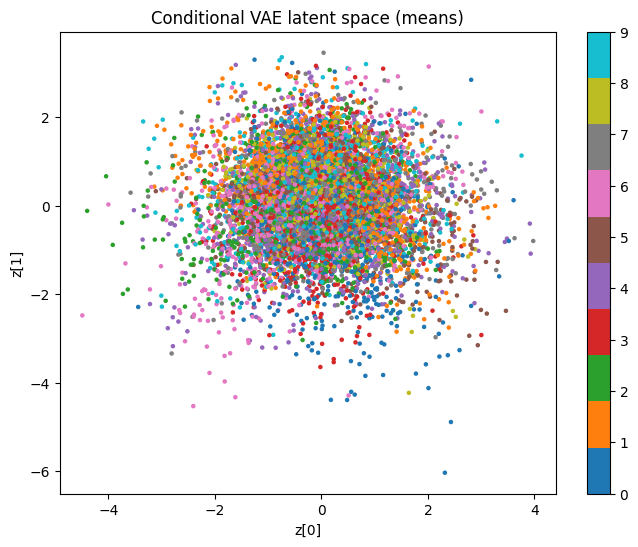

In [25]:
image_dim = 28 * 28

def plot_latent_space(model, loader, device):
    model.eval()
    zs = []
    labels = []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device).view(-1, image_dim)
            y_onehot = one_hot(y_batch.to(device), num_classes, device)
            z_mean, z_logvar = model.encoder(x_batch, y_onehot)
            zs.append(z_mean.cpu().numpy())
            labels.append(y_batch.numpy())

    z = np.concatenate(zs, axis=0)
    labels = np.concatenate(labels, axis=0)

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="tab10", s=5)
    plt.colorbar(sc)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Conditional VAE latent space (means)")
    plt.show()

plot_latent_space(vae, test_loader, device)


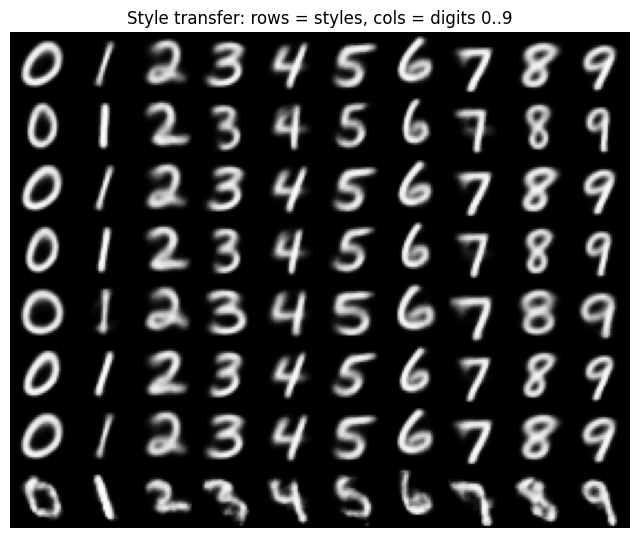

In [26]:
def style_transfer_grid(model, loader, device, n_styles=8):
    model.eval()
    # візьмемо перші n_styles прикладів з test_loader
    xs = []
    ys = []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            xs.append(x_batch)
            ys.append(y_batch)
            if len(torch.cat(xs)) >= n_styles:
                break

    x_samples = torch.cat(xs)[:n_styles].to(device)      # [n,1,28,28]
    y_samples = torch.cat(ys)[:n_styles].to(device)      # [n]

    x_flat = x_samples.view(-1, image_dim)
    y_onehot = one_hot(y_samples, num_classes, device)

    with torch.no_grad():
        z_mean, z_logvar = model.encoder(x_flat, y_onehot)
        z_styles = z_mean   # беремо mean як стиль

    # Створимо картинку: n_styles рядків, 10 колонок (цифри 0..9)
    digit_size = 28
    figure = np.zeros((n_styles * digit_size, 10 * digit_size))

    with torch.no_grad():
        for row in range(n_styles):
            z = z_styles[row:row+1]              # [1,2]
            for d in range(10):
                y_t = torch.tensor([d], device=device)
                y_t_oh = one_hot(y_t, num_classes, device)
                x_dec = model.decoder(z, y_t_oh)
                digit = x_dec.cpu().numpy().reshape(digit_size, digit_size)

                r0 = row * digit_size
                r1 = (row + 1) * digit_size
                c0 = d * digit_size
                c1 = (d + 1) * digit_size
                figure[r0:r1, c0:c1] = digit

    plt.figure(figsize=(8, 8))
    plt.imshow(figure, cmap="Greys_r")
    plt.axis("off")
    plt.title("Style transfer: rows = styles, cols = digits 0..9")
    plt.show()

style_transfer_grid(vae, test_loader, device, n_styles=8)


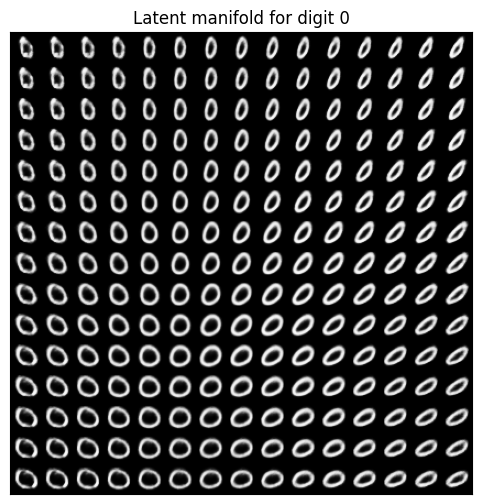

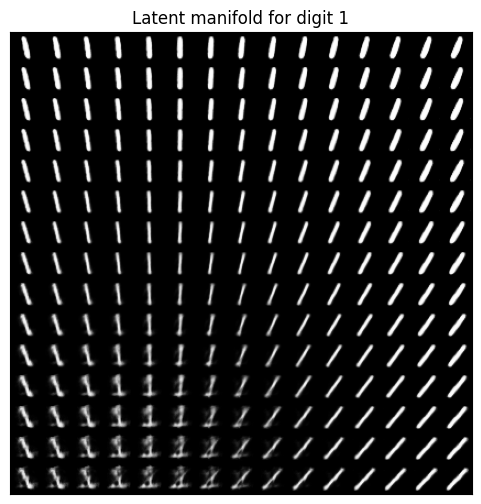

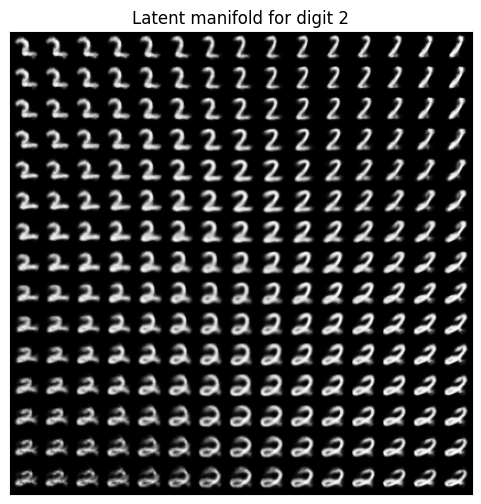

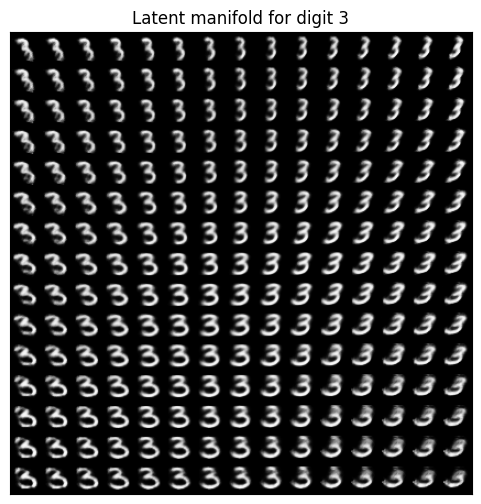

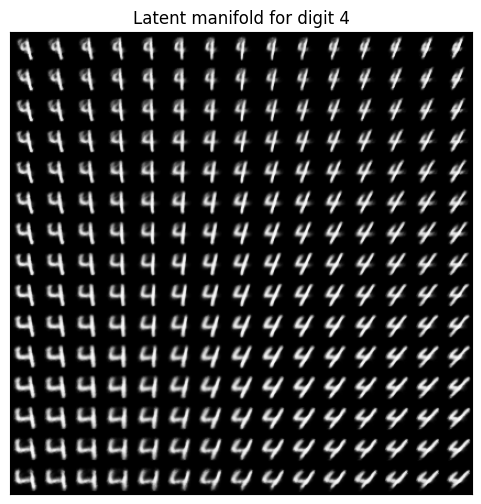

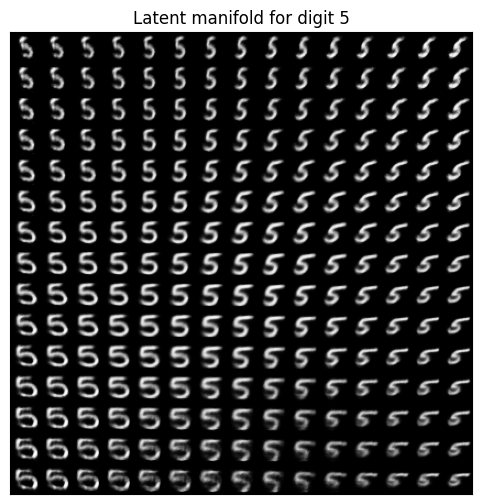

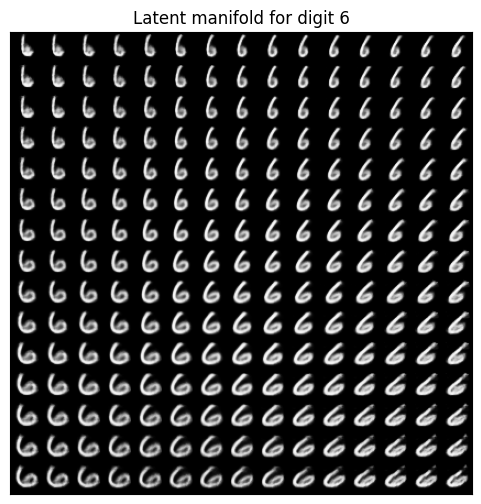

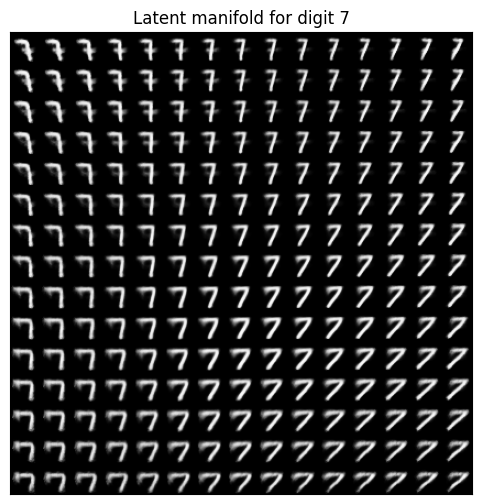

In [27]:
def manifold_for_digit(model, digit, device, n=20, z_range=2.5):
    """
    Малює n x n маніфолд для заданої цифри (label=digit) у просторі z.
    """
    model.eval()
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-z_range, z_range, n)
    grid_y = np.linspace(-z_range, z_range, n)[::-1]

    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z = torch.tensor([[xi, yi]], dtype=torch.float32, device=device)
                y_t = torch.tensor([digit], device=device)
                y_t_oh = one_hot(y_t, num_classes, device)
                x_dec = model.decoder(z, y_t_oh)
                digit_img = x_dec.cpu().numpy().reshape(digit_size, digit_size)

                r0 = i * digit_size
                r1 = (i + 1) * digit_size
                c0 = j * digit_size
                c1 = (j + 1) * digit_size
                figure[r0:r1, c0:c1] = digit_img

    plt.figure(figsize=(6, 6))
    plt.imshow(figure, cmap="Greys_r")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Latent manifold for digit {digit}")
    plt.show()

# приклад: намалювати для кількох цифр
for d in [0, 1, 2, 3, 4, 5, 6, 7]:
    manifold_for_digit(vae, d, device, n=15, z_range=2.5)
